# Predictive Modelling: CNN

Author: Frauke Albrecht
<div>
<img src="cells.png" width="600"/>
</div>  

Image by Blausen Medical - BruceBlaus. When using this image in external sources it can be cited as:Blausen.com staff (2014). "Medical gallery of Blausen Medical 2014". WikiJournal of Medicine 1 (2). DOI:10.15347/wjm/2014.010. ISSN 2002-4436., CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=56845134

**Objective:**

In this notebook, we will consider the **classification of the white blood cells in four classes**. Each of the given cell type will be classified. In order to do that we will build a **Convolutional Neural Network (CNN)** using Tensorflow.

Parts of this notebook have been adapted from the tutorial https://www.tensorflow.org/tutorials/images/classification.

## Setup

In [731]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Read the Data

Read the data from the directory and print how many images we have for each class.

In [512]:
# path containing the training data
train_dir = 'dataset2-master/dataset2-master/images/TRAIN/train_img/'
# path containing the test data
val_dir = 'dataset2-master/dataset2-master/images/TEST/test_img/'

In [513]:
# directories with training pictures of each type
train_eos_dir = os.path.join(train_dir, 'eosinophil')  
train_neu_dir = os.path.join(train_dir, 'neutrophil') 
train_lym_dir = os.path.join(train_dir, 'lymphocyte')  
train_mon_dir = os.path.join(train_dir, 'monocyte') 
# directories with test pictures of each type
val_eos_dir = os.path.join(val_dir, 'eosinophil')  
val_neu_dir = os.path.join(val_dir, 'neutrophil')  
val_lym_dir = os.path.join(val_dir, 'lymphocyte')
val_mon_dir = os.path.join(val_dir, 'monocyte')

In [514]:
# How many pictures do we have?
num_eos_tr = len(os.listdir(train_eos_dir))
num_neu_tr = len(os.listdir(train_neu_dir))
num_lym_tr = len(os.listdir(train_lym_dir))
num_mon_tr = len(os.listdir(train_mon_dir))

num_eos_val = len(os.listdir(val_eos_dir))
num_neu_val = len(os.listdir(val_neu_dir))
num_lym_val = len(os.listdir(val_lym_dir))
num_mon_val = len(os.listdir(val_mon_dir))

total_train = num_eos_tr + num_neu_tr + num_lym_tr + num_mon_tr
total_val  = num_eos_val + num_neu_val + num_lym_val + num_mon_val

In [515]:
print('total training eosinophil images:', num_eos_tr)
print('total training neutrophil images:', num_neu_tr)
print('total training lymphocyte images:', num_lym_tr)
print('total training monocyte images:', num_mon_tr)

print('total validation eosinophil images:', num_eos_val)
print('total validation neutrophil images:', num_neu_val)
print('total validation lymphocyte images:', num_lym_val)
print('total validation monocyte images:', num_mon_val)
print("-"*20)
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training eosinophil images: 2497
total training neutrophil images: 2499
total training lymphocyte images: 2483
total training monocyte images: 2478
total validation eosinophil images: 623
total validation neutrophil images: 624
total validation lymphocyte images: 620
total validation monocyte images: 620
--------------------
Total training images: 9957
Total validation images: 2487


In [516]:
class_names = ['Eosinophil', 'Neutrophil', 'Lymphocyte', 'Monocyte']

## Prepare the Data for Modelling

The data needs to be in an appropiate format in order to start modelling. The class ```ImageDataGenerator``` is usefull for that. It can read images from the disk and transform them into tensors. We will rescale the images by 1/255 in order to hava numbers between 0 and 1. The generators are defined for training and test dataset and then the ```flow_from_directory``` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [517]:
batch_size = 128
epochs     = 100
IMG_HEIGHT = 60#240
IMG_WIDTH  = 80#320

In [518]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator  = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [519]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

Found 9957 images belonging to 4 classes.


In [520]:
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='sparse')

Found 2487 images belonging to 4 classes.


## Visualize some Images

We use the ```next```function, which returns a batch from the dataset and its target values. As we set the batch size to 128, in our case it returns 128 images

In [439]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [440]:
print("Shape of a sample batch of images: {}".format(sample_training_images.shape))
print("Shape of a sample lables: {}".format(sample_training_labels.shape))

Shape of a sample batch of images: (128, 60, 80, 3)
Shape of a sample lables: (128,)


In [441]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels):
    i = 0
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title("label =" + str(labels[i]))
        i+=1
    plt.tight_layout()
    plt.show()

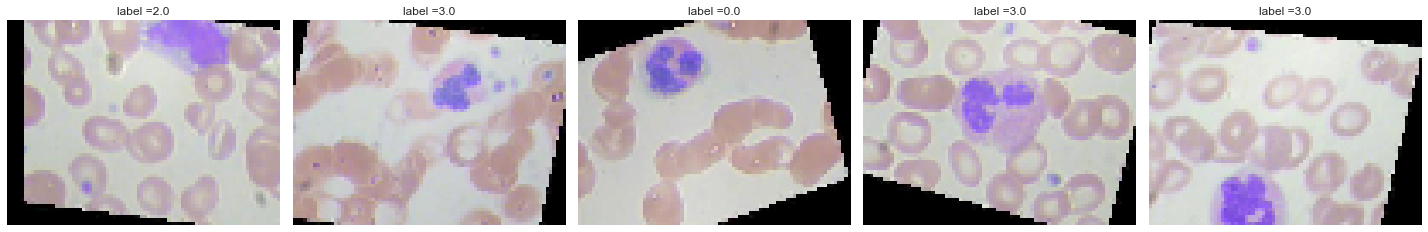

In [442]:
plotImages(sample_training_images[:5], sample_training_labels[:5])

## Create a Model 

The model consists of 2 convolutional layers with relu activation, followed by max pooling and a dense layer with relu activation and finally the output layer with a softmax activation. We train on the number of epochs defined above, but additionally include an early stopping with a patience of 3, that is the training will stop, when there is no improvement after 3 steps. We use ADAM optimizer and sparse cross entropy loss function as we have 4 classes and every image is related to exactly one class. That is we don't have mulitlables.

In [443]:
# define the model
model =Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

In [444]:
# print a summary of the model
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 13, 18, 64)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 14976)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               1917056   
_________________________________________________________________
dense_49 (Dense)             (None, 4)               

In [445]:
# compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)
model.compile(optimizer='adam',            
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],callbacks=[callback])

In [446]:
# train the model
 model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/100
77/77 [==============================] - 139s 2s/step - loss: 1.3901 - accuracy: 0.2583 - val_loss: 1.3820 - val_accuracy: 0.3363
Epoch 2/100
77/77 [==============================] - 176s 2s/step - loss: 1.3469 - accuracy: 0.3564 - val_loss: 1.2971 - val_accuracy: 0.4079
Epoch 3/100
77/77 [==============================] - 202s 3s/step - loss: 1.2805 - accuracy: 0.4352 - val_loss: 1.2536 - val_accuracy: 0.4638
Epoch 4/100
77/77 [==============================] - 203s 3s/step - loss: 1.2233 - accuracy: 0.5052 - val_loss: 1.1782 - val_accuracy: 0.5362
Epoch 5/100
77/77 [==============================] - 753s 10s/step - loss: 1.1733 - accuracy: 0.5650 - val_loss: 1.1530 - val_accuracy: 0.5683
Epoch 6/100
77/77 [==============================] - 201s 3s/step - loss: 1.1428 - accuracy: 0.5896 - val_loss: 1.1344 - val_accuracy: 0.5933
Epoch 7/100
77/77 [==============================] - 204s 3s/step - loss: 1.0988 - accuracy: 0.6403 - val_loss: 1.1057 - val_accuracy: 0.6238
Epoch

In [447]:
def plot_acc_loss(acc, val_acc, loss, val_loss):

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, color="#58D68D", linewidth=2, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, color="#F1C40F", linewidth=2, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylim(0,1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, color="#58D68D", linewidth=2, label='Training Loss')
    plt.plot(epochs_range, val_loss, color="#F1C40F", linewidth=2, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

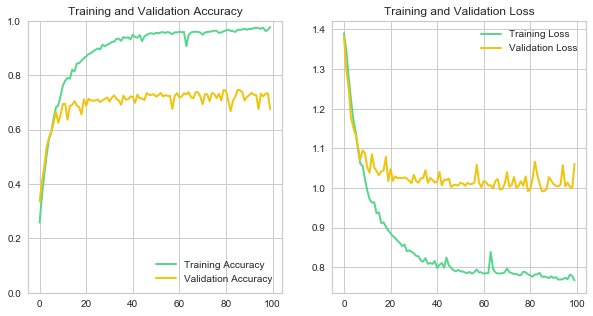

In [448]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

The results show that the model is overfiffing. The training accuracy is rising to more than 95% within 25 epochs, while the validation accuracy is stagnating at about 66%. Analogue the loss of the training is falling much lower than the validation loss.  

## Improve the Model

We added dropout after each max pooling and after the dense layer. This improves the accuracy of the model in the test set.

In [110]:
# define the model
model2 =Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),strides=1),#padding=same?
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [111]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 18, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 18, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 14976)            

In [112]:
# compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)
model2.compile(optimizer='adam',            
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],callbacks=[callback])

In [113]:
# train the model
history2 = model2.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/100
77/77 [==============================] - 235s 3s/step - loss: 1.3927 - accuracy: 0.2506 - val_loss: 1.3842 - val_accuracy: 0.3388
Epoch 2/100
77/77 [==============================] - 194s 3s/step - loss: 1.3591 - accuracy: 0.3291 - val_loss: 1.2885 - val_accuracy: 0.4067
Epoch 3/100
77/77 [==============================] - 190s 2s/step - loss: 1.3020 - accuracy: 0.4029 - val_loss: 1.2560 - val_accuracy: 0.4371
Epoch 4/100
77/77 [==============================] - 223s 3s/step - loss: 1.2645 - accuracy: 0.4509 - val_loss: 1.2276 - val_accuracy: 0.4827
Epoch 5/100
77/77 [==============================] - 194s 3s/step - loss: 1.2099 - accuracy: 0.5217 - val_loss: 1.2156 - val_accuracy: 0.5164
Epoch 6/100
77/77 [==============================] - 217s 3s/step - loss: 1.1694 - accuracy: 0.5647 - val_loss: 1.1879 - val_accuracy: 0.5243
Epoch 7/100
77/77 [==============================] - 171s 2s/step - loss: 1.1513 - accuracy: 0.5787 - val_loss: 1.1573 - val_accuracy: 0.5711
Epoch 

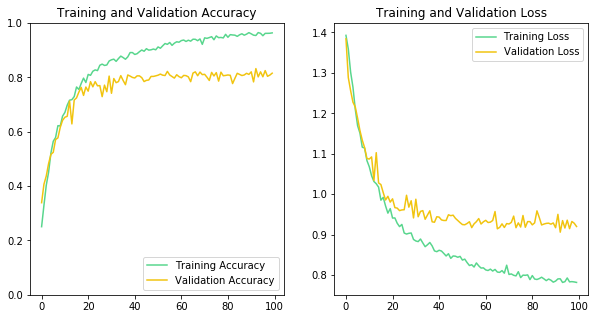

In [114]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

In [115]:
tf.keras.models.save_model(
    model=model2, filepath="model2", overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model2/assets


In [116]:
#tf.saved_model.load(
#    export_dir="model2", tags=None
#)

Including the dropouts improved the model's performance. The accuracy on the test set rises to about 80%.

## Include Batch Normalization
Including dropout improved the accuracy on the test set, we now include a third convolutional layer and batch normalization after the Dense layer. That is, the batch is normalized before it is going to the next layer. Batch normalization has regularization effects, similar to dropout. We only leave the dropout after the dense layer. Tests showed that including more dropouts does not improve the model performance.

In [528]:
# Include BatchNormalisation 
model3 =Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),strides=1),#padding=same?   
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(input_shape=(60, 80, 3)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [529]:
# print a summary of the model
model3.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 13, 18, 64)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 11, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 5, 8, 64)          0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 5, 8, 64)        

In [531]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)
model3.compile(optimizer='adam',            
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],callbacks=[callback])

In [532]:
# train the model
history3 = model3.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/100
77/77 [==============================] - 150s 2s/step - loss: 1.4175 - accuracy: 0.2502 - val_loss: 1.4900 - val_accuracy: 0.2484
Epoch 2/100
77/77 [==============================] - 161s 2s/step - loss: 1.4123 - accuracy: 0.2590 - val_loss: 1.4874 - val_accuracy: 0.2484
Epoch 3/100
77/77 [==============================] - 144s 2s/step - loss: 1.3465 - accuracy: 0.3399 - val_loss: 1.4060 - val_accuracy: 0.2500
Epoch 4/100
77/77 [==============================] - 141s 2s/step - loss: 1.1908 - accuracy: 0.5335 - val_loss: 1.3835 - val_accuracy: 0.2845
Epoch 5/100
77/77 [==============================] - 155s 2s/step - loss: 1.0341 - accuracy: 0.7205 - val_loss: 1.3462 - val_accuracy: 0.3639
Epoch 6/100
77/77 [==============================] - 185s 2s/step - loss: 0.9773 - accuracy: 0.7727 - val_loss: 1.2856 - val_accuracy: 0.3960
Epoch 7/100
77/77 [==============================] - 251s 3s/step - loss: 0.9464 - accuracy: 0.8019 - val_loss: 1.1878 - val_accuracy: 0.5358
Epoch 

77/77 [==============================] - 259s 3s/step - loss: 0.8241 - accuracy: 0.9203 - val_loss: 0.9135 - val_accuracy: 0.8273
Epoch 59/100
77/77 [==============================] - 265s 3s/step - loss: 0.8265 - accuracy: 0.9159 - val_loss: 0.9207 - val_accuracy: 0.8178
Epoch 60/100
77/77 [==============================] - 294s 4s/step - loss: 0.8188 - accuracy: 0.9251 - val_loss: 0.9192 - val_accuracy: 0.8224
Epoch 61/100
77/77 [==============================] - 264s 3s/step - loss: 0.8237 - accuracy: 0.9198 - val_loss: 0.9021 - val_accuracy: 0.8372
Epoch 62/100
77/77 [==============================] - 262s 3s/step - loss: 0.8181 - accuracy: 0.9263 - val_loss: 0.9018 - val_accuracy: 0.8355
Epoch 63/100
77/77 [==============================] - 262s 3s/step - loss: 0.8165 - accuracy: 0.9271 - val_loss: 0.9084 - val_accuracy: 0.8310
Epoch 64/100
77/77 [==============================] - 257s 3s/step - loss: 0.8228 - accuracy: 0.9217 - val_loss: 0.9249 - val_accuracy: 0.8150
Epoch 65/100

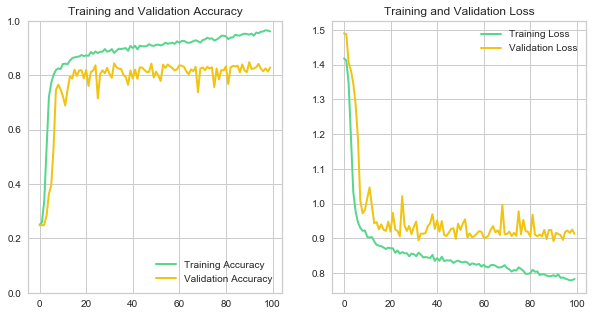

In [533]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

In [534]:
tf.keras.models.save_model(
    model=model3, filepath="model3.h5", overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None
)

In [535]:
#tf.saved_model.load(
#    export_dir="model3.h5", tags=None
#)

This third model further improves the accuracy. A maximal accuracy of 85% is obtained and a mean of more than 80% during the last training epochs.

## Make Predictions

Use the model to make predictions and plot some results.

In [583]:
#predictions = model2.predict(validation_data_gen)
sample_test_images, sample_test_labels = next(validation_data_gen)
predictions = model3.predict(sample_test_images)

In [587]:
print("SOME PREDICTIONS:")
for i in range(5,10):
    print("-"*20)
    print("Prediction values of the first image: {}".format(predictions[i]))
    print("Predicted cell type of the first image: {}.".format(np.argmax(predictions[i])))
    print("True label: {}".format(int(sample_test_labels[i])))

SOME PREDICTIONS:
--------------------
Prediction values of the first image: [3.2635238e-12 3.9501874e-17 1.2874667e-14 1.0000000e+00]
Predicted cell type of the first image: 3.
True label: 3
--------------------
Prediction values of the first image: [5.9033101e-07 6.9603372e-11 9.2105449e-07 9.9999845e-01]
Predicted cell type of the first image: 3.
True label: 3
--------------------
Prediction values of the first image: [1.0000000e+00 4.5909153e-13 1.2628742e-16 1.3029624e-12]
Predicted cell type of the first image: 0.
True label: 0
--------------------
Prediction values of the first image: [7.2245859e-02 9.2337674e-01 1.6448475e-06 4.3757022e-03]
Predicted cell type of the first image: 1.
True label: 1
--------------------
Prediction values of the first image: [1.0000000e+00 2.0845482e-08 7.2937810e-12 2.5353165e-08]
Predicted cell type of the first image: 0.
True label: 0


In [588]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = '#009933'
    else:
        color = '#cc0000'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(4))
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#cc0000')
    thisplot[true_label].set_color('#009933')

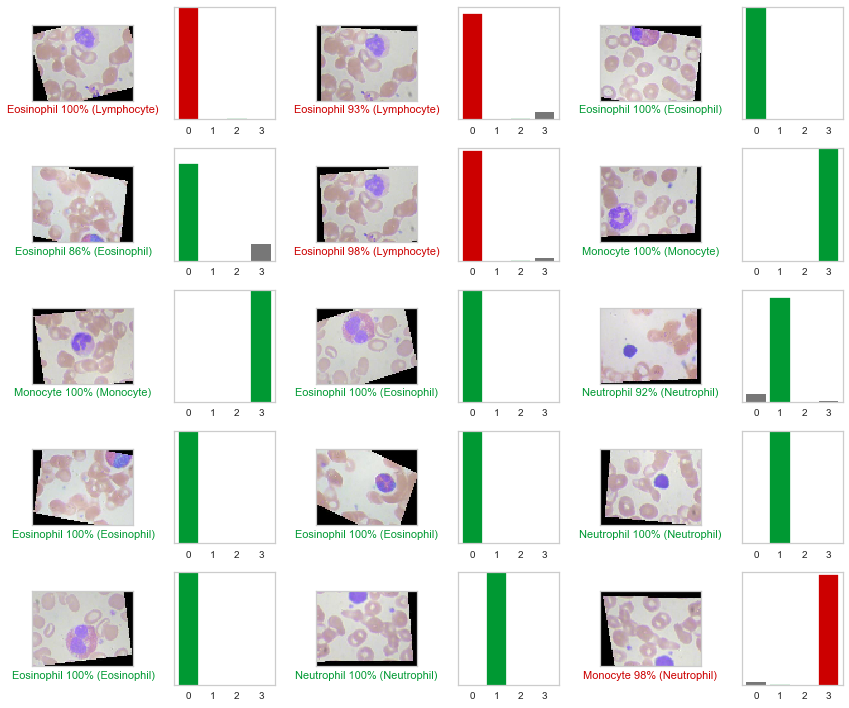

In [728]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# Color correct predictions in green and incorrect predictions in red.
test_labels = sample_test_labels
test_images = sample_test_images
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Visualizations

Visualize the filters in the convolutional layers. Our model contains three convolutional layers, we consider them separately.

The following code has been adapted from https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [590]:
# print the layers of the model 
model3.layers

In [591]:
# summarize filters and shapes in each convolutional layer
print("Summary of convolutional layers in the CNN:")
print("-"*30)
for layer in model3.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

Summary of convolutional layers in the CNN:
------------------------------
conv2d_98 (3, 3, 3, 32)
conv2d_99 (3, 3, 32, 64)
conv2d_100 (3, 3, 64, 64)


In [593]:
# summarize feature map shape (=output shape) for each conv layer
print("Summary of convolutional layers' output (feature map) in the CNN:")
print("-"*30)
for i in range(len(model3.layers)):
    layer = model3.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

Summary of convolutional layers' output (feature map) in the CNN:
------------------------------
0 conv2d_98 (None, 58, 78, 32)
2 conv2d_99 (None, 27, 37, 64)
4 conv2d_100 (None, 11, 16, 64)


### First Convolutional Layer

The first convolutional layer consists of 32 filters. Each of the shape 3x3 for 3 channels. For visualisation we plot the first six filters. Each row represents one filter and each coloumn one channel. The filter values are normalized to values between 0 and 1 to visualize them. With this scaling dark values reflect small weights and light values large weights. A change between black and white squares represent a  gradient from light to dark.

We define a model that returns the output after the first convolutional layer and plot the results. All 32 images for all filters. Some filters detect the white blood cell and some the background (red cells).

In [594]:
# retrieve weights from the i-th hidden layer
def weights(layer_nr):
    filters, biases = model3.layers[layer_nr].get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first few filters
    fig = plt.figure(figsize=(10, 10))
    n_filters, ix = 6, 1
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(3):
            # specify subplot and turn of axis
            ax = plt.subplot(n_filters, 3, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
            plt.title("channel " + str(j+1))
            plt.ylabel("filter " + str(i+1))
            ix += 1
    # show the figure
    plt.show()

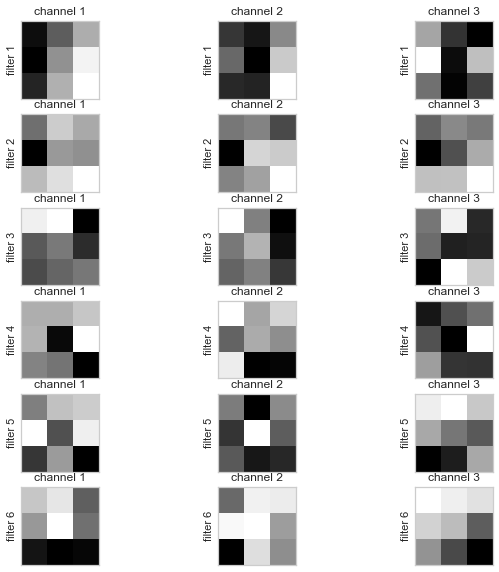

In [595]:
weights(0)

In [596]:
# redefine model to output right after the first hidden layer
model_0 = tf.keras.Model(inputs=model3.inputs, outputs=model3.layers[0].output)

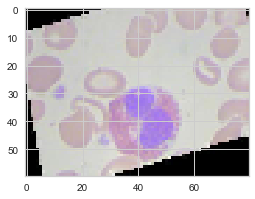

In [712]:
# test image
exp = 52
img = sample_test_images[exp]
# plot test image
plt.figure(figsize=(4, 4))
plt.imshow(img)
# convert the image to an array
img = tf.keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# get feature map for first hidden layer
feature_maps = model_0.predict(img)

In [713]:
print("Predicted Label: {} ({})".format(np.argmax(predictions[exp]), class_names[np.argmax(predictions[exp])]))
print("True Label: {} ({})".format(int(test_labels[exp]), class_names[int(test_labels[exp])]))

Predicted Label: 0 (Eosinophil)
True Label: 0 (Eosinophil)


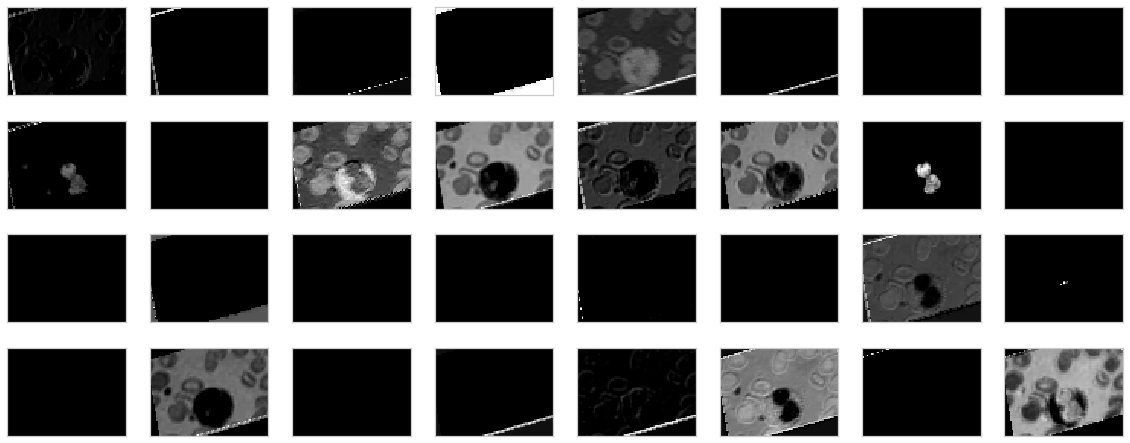

In [714]:
# plot all 32 maps in an 4x8 squares
square = 8
ix = 1
plt.figure(figsize=(20, 8))
for _ in range(square):
    for _ in range(int(square/2)):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square/2, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show();

### Second Convolutional Layer

The second convolutional layer consists of 64 filters. Each of the shape 3x3 for 3 channels. For visualisation we plot the first six filters. The plot is analogue to the one of the first convolutional layer. Again we define a model that returns the output that gives the second convolutional layer (feature maps). The feature maps show more general features than after the first convolutional layer. 

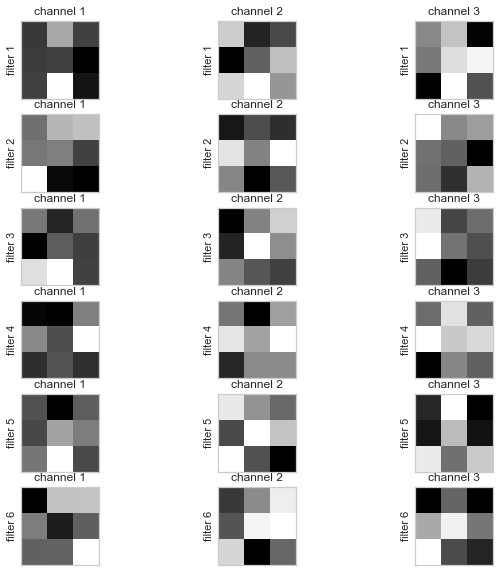

In [715]:
weights(2)

In [716]:
# redefine model to output right after the first hidden layer
model_1 = tf.keras.Model(inputs=model3.inputs, outputs=model3.layers[2].output)
feature_maps = model_1.predict(img)

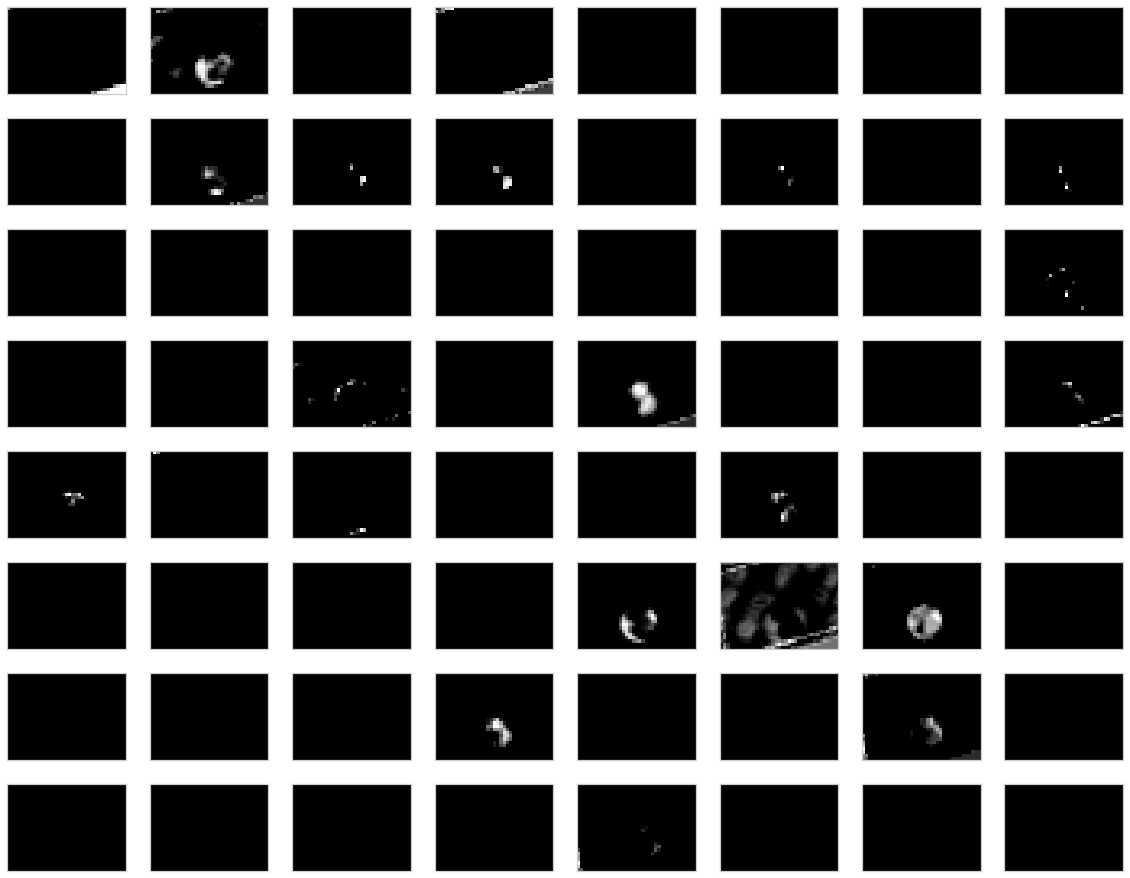

In [717]:
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(20, 16))
for _ in range(square):
    for _ in range(int(square)):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show();

### Third Convolutional Layer

The thirs convolutional layer consists of 64 filters. Each of the shape 3x3 for 3 channels. Visualizations are analogue as above

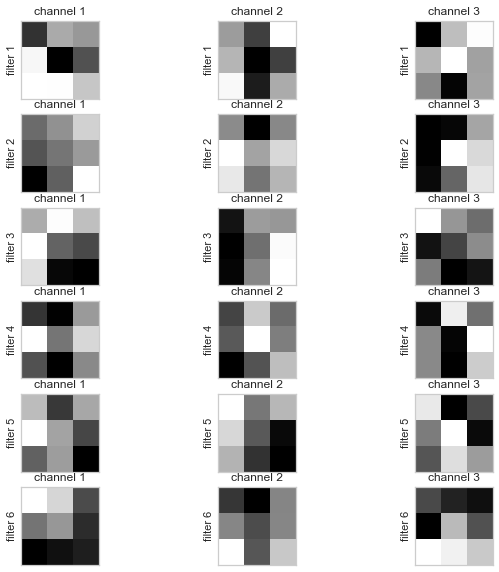

In [718]:
weights(4)

In [719]:
# redefine model to output right after the first hidden layer
model_2 = tf.keras.Model(inputs=model3.inputs, outputs=model3.layers[4].output)
feature_maps = model_2.predict(img)

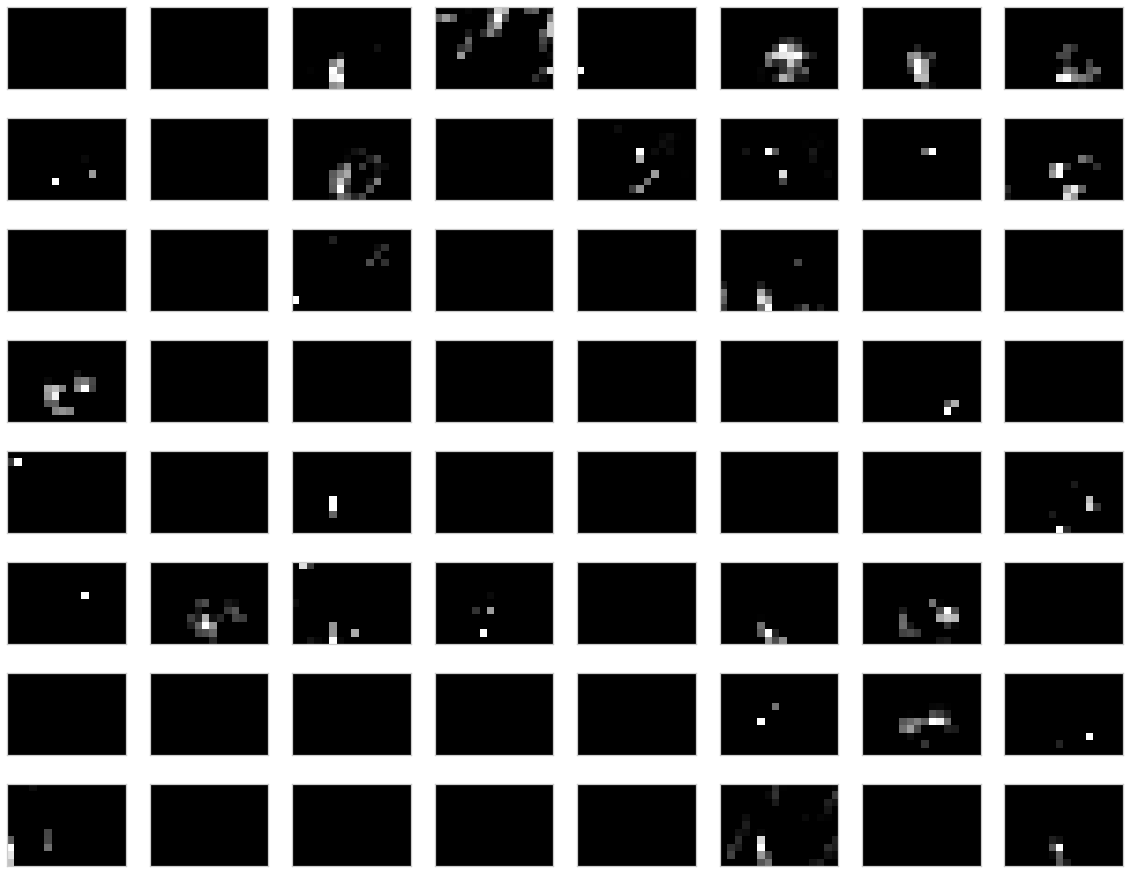

In [720]:
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(20, 16))
for _ in range(square):
    for _ in range(int(square)):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show();

# Conclusions

We developed a CNN for the classification of four different types of white blood cells. Our model achieves an accuracy of more than 80% (maximum 85%) after 100 epochos of training. This is the first step to a more complex problem. In reality it is not only important to classify white blood cells, but also to count them. A medical diagnosis depends not only on the type of cell, but also on the amount of white and red blood cells in a sample. 

# Future Work

* Improve Accuracy of the current classification problem by optimizing hyperparameters

* Detect more than one cell on the image (maybe of different kinds)

* Use object detection to localize and count the types of white blood cells (bounding boxes are given for the original images)

* Further classification: 
    * Get more images from basophils to include this group into the model
    * Cell types can be subdivided in more types (e.g. there are several types of lymphocytes)